# Notebook for Clostest cell model
Starting with PCA embeddings of RNA, using Linear Regression to predict how a clone responses to vaccination in a late time point, using data from P1 (initial time point) to predcit S1 and T1


In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [2]:
import pandas as pd
import numpy as np
import scirpy as ir
import anndata as ad
import scanpy as sc
from matplotlib import rcParams
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingRegressor 
import matplotlib.pyplot as plt
import moscot
from sklearn.metrics import mean_squared_error, r2_score

/opt/anaconda3/envs/vaccineSimulator/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Get data & explore data

In [3]:
adata = sc.read_h5ad('/Users/juliakuhn/Desktop/uni/WS2425/cmscb/Project_phase/VaccineSimulator/02_dex_annotated_cd8.h5ad')
adata

AnnData object with n_obs × n_vars = 53907 × 18471
    obs: 'is_cell', 'high_confidence', 'multi_chain', 'extra_chains', 'IR_VJ_1_c_call', 'IR_VJ_2_c_call', 'IR_VDJ_1_c_call', 'IR_VDJ_2_c_call', 'IR_VJ_1_consensus_count', 'IR_VJ_2_consensus_count', 'IR_VDJ_1_consensus_count', 'IR_VDJ_2_consensus_count', 'IR_VJ_1_d_call', 'IR_VJ_2_d_call', 'IR_VDJ_1_d_call', 'IR_VDJ_2_d_call', 'IR_VJ_1_duplicate_count', 'IR_VJ_2_duplicate_count', 'IR_VDJ_1_duplicate_count', 'IR_VDJ_2_duplicate_count', 'IR_VJ_1_j_call', 'IR_VJ_2_j_call', 'IR_VDJ_1_j_call', 'IR_VDJ_2_j_call', 'IR_VJ_1_junction', 'IR_VJ_2_junction', 'IR_VDJ_1_junction', 'IR_VDJ_2_junction', 'IR_VJ_1_junction_aa', 'IR_VJ_2_junction_aa', 'IR_VDJ_1_junction_aa', 'IR_VDJ_2_junction_aa', 'IR_VJ_1_locus', 'IR_VJ_2_locus', 'IR_VDJ_1_locus', 'IR_VDJ_2_locus', 'IR_VJ_1_productive', 'IR_VJ_2_productive', 'IR_VDJ_1_productive', 'IR_VDJ_2_productive', 'IR_VJ_1_v_call', 'IR_VJ_2_v_call', 'IR_VDJ_1_v_call', 'IR_VDJ_2_v_call', 'has_ir', 'LTDEMIAQY', 'YTN

# Creat RNA Embeddings with PCA
Here, the sc.tl.pca was utlized, with manually selecting the number of principal components with the use of a variance ratio plot. Alternatively, one could use sklearn.PCA  
PCA embeddings are saved automatically in adata.obsm["X_pca"]

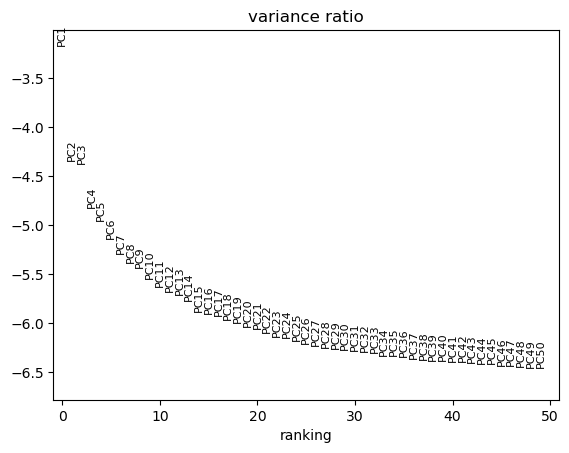

In [4]:
pca_adata = adata.copy()
sc.tl.pca(pca_adata)
sc.pl.pca_variance_ratio(pca_adata, log=True, n_pcs=50) # Elbow plot

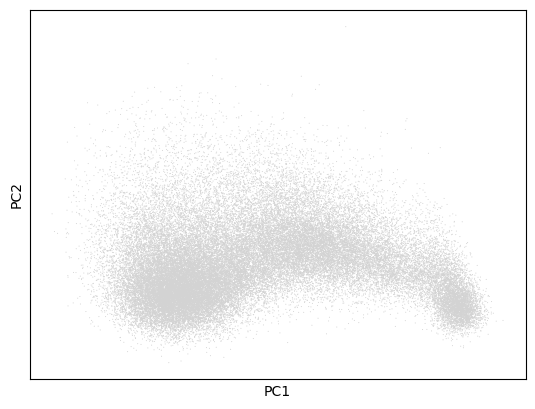

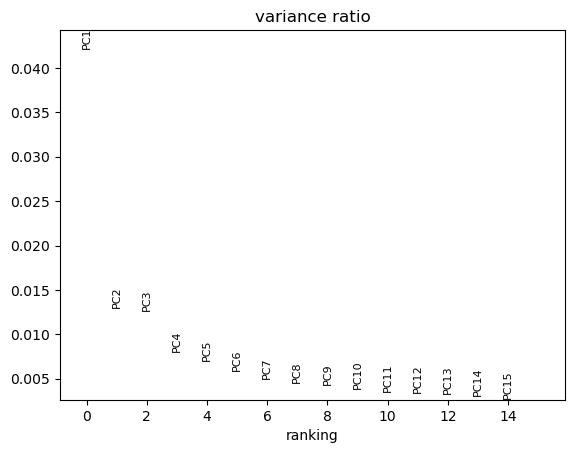

In [5]:
sc.tl.pca(adata, n_comps=15) # Perform PCA -> use 15 components since they explain 90% of the variance (plot)
sc.pl.pca(adata) # Plot only the top two principal components as they are most informative
sc.pl.pca_variance_ratio(adata, n_pcs=15) 

In [6]:
adata.obsm["X_pca"] # check if PCA was stored in adata

array([[ 7.353599  ,  2.2930684 ,  5.475095  , ..., -0.42035165,
        -0.49188307, -0.7464614 ],
       [ 8.438534  , -4.256931  ,  2.3050709 , ...,  2.3662179 ,
         0.58670783, -0.10710645],
       [-3.9699266 ,  9.784491  ,  1.751464  , ...,  2.0638733 ,
         2.7388659 , -2.1804137 ],
       ...,
       [-4.581481  , -1.3408933 ,  1.0974716 , ..., -1.164471  ,
        -1.8378661 , -0.43813595],
       [-3.7005863 , -1.7343283 , -1.1275568 , ..., -1.7393296 ,
         0.7136808 ,  0.39433032],
       [-2.018728  ,  1.920088  , -4.796494  , ...,  0.93350214,
         0.43976098,  0.09896234]], dtype=float32)

# Clone Aggregation and Pairing:
For each clone early and late time point data is paired.
Not all clones in P1 might exist in S1 or T1. Here, we ensure that only clones with valid response scores are included in the model training.

In [7]:
# filter out cells that we can't use
adata = adata[~adata.obs.clone_id.isna()]
adata = adata[~(adata.obs.clone_id=='nan')]
adata = adata[~(adata.obs.time.isin(['X3','extra']))]

In [8]:
# Filter for time points
P1_mask = adata.obs["time"] == "P1"
S1_mask = adata.obs["time"] == "S1"
T1_mask = adata.obs["time"] == "T1"

# Features: Embeddings from P1
X_p1 = adata[P1_mask].obsm["X_pca"]
X_s1 = adata[S1_mask].obsm["X_pca"]
X_t1 = adata[T1_mask].obsm["X_pca"]

# get target variable and clones from S1 and T1
S1_clones = adata[S1_mask].obs["clone_id"].values  # Clonotypes at S1
S1_targets = adata[S1_mask].obs["IFN Response_score"].values # target variable

T1_clones = adata[T1_mask].obs["clone_id"].values  # Clonotypes at T1
T1_targets = adata[T1_mask].obs["IFN Response_score"].values # target variable

P1_clones = adata[P1_mask].obs["clone_id"].values
P1_targets = adata[P1_mask].obs["IFN Response_score"].values  

In [9]:
# Map S1 and T1 responses to corresponding P1 clones to ensure that only clones with corresponding targets are included
s1 = np.array([S1_targets[np.where(S1_clones == cid)[0][0]] if cid in S1_clones else np.nan for cid in P1_clones])
t1 = np.array([T1_targets[np.where(T1_clones == cid)[0][0]] if cid in T1_clones else np.nan for cid in P1_clones])
p1 = np.array([P1_targets[np.where(P1_clones == cid)[0][0]] if cid in P1_clones else np.nan for cid in P1_clones])

# Remove clones without corresponding targets
valid_indices = ~np.isnan(s1) & ~np.isnan(t1)
X_p1, s1, t1, p1 = X_p1[valid_indices], s1[valid_indices], t1[valid_indices], p1[valid_indices]
P1_clones = P1_clones[valid_indices]
unique_clonotypes_aggregated = np.unique(P1_clones) # Unique clonotypes in the aggregated data

# Train- Test Split

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd

# X_aggregated (features), P1_clones (clonotype labels), 
# y_s1_aggregated (true target values for S1), y_p1_aggregated (true target values for P1),
# y_s1_pred (predicted values for each cell), and y_p1_pred (predictions for each cell).
# Recreate aggregated arrays aligned with unique clonotypes
X_aggregated = []  # features
y_s1_aggregated = [] # target values for s1
y_t1_aggregated = []
y_p1_aggregated = []
X_s1_aggregated = []  # features S1 
X_p1_aggregated = []  # features P1
X_t1_aggregated = []  # features T1

# Step 1: Split the clonotypes into train, test, and eval sets
train_clonotypes, temp_clonotypes = train_test_split(unique_clonotypes_aggregated, test_size=0.3, random_state=42)

# Then split temp_clonotypes into test and eval (50% each)
test_clonotypes, eval_clonotypes = train_test_split(temp_clonotypes, test_size=0.5, random_state=42)

# Create masks for train, test, and eval sets based on clonotypes
train_mask = np.isin(unique_clonotypes_aggregated, train_clonotypes)
test_mask = np.isin(unique_clonotypes_aggregated, test_clonotypes)
eval_mask = np.isin(unique_clonotypes_aggregated, eval_clonotypes)

# Step 2: 
# Loop to aggregate the features for each clonotype
for clone in unique_clonotypes_aggregated:
    mask = P1_clones == clone  # Select rows matching the current clone for P1
    X_p1_aggregated.append(X_p1[mask].mean(axis=0))  # Mean of features for P1
    y_s1_aggregated.append(s1[mask].mean())      # Mean of s1 for the clone
    y_t1_aggregated.append(t1[mask].mean())      # Mean of t1 for the clone
    y_p1_aggregated.append(p1[mask].mean())      # Mean of p1 for the clone

    mask = S1_clones == clone  # Select rows matching the current clone for S1
    X_s1_aggregated.append(X_s1[mask].mean(axis=0))  # Mean of features for S1

    mask = T1_clones == clone  # Select rows matching the current clone for T1
    X_t1_aggregated.append(X_t1[mask].mean(axis=0))  # Mean of features for T1


# Convert lists to arrays
X_aggregated = np.array(X_aggregated)
y_s1_aggregated = np.array(y_s1_aggregated)
y_t1_aggregated = np.array(y_t1_aggregated)
y_p1_aggregated = np.array(y_p1_aggregated)
X_s1_aggregated = np.array(X_s1_aggregated)
X_t1_aggregated = np.array(X_t1_aggregated)
X_p1_aggregated = np.array(X_p1_aggregated)

# Split aggregated data into train and test sets
#X_train, X_test = X_aggregated[train_mask], X_aggregated[test_mask]
X_p1_train, X_p1_test = X_p1_aggregated[train_mask], X_p1_aggregated[test_mask]
X_s1_train, X_s1_test = X_s1_aggregated[train_mask], X_s1_aggregated[test_mask]
X_t1_train, X_t1_test = X_t1_aggregated[train_mask], X_t1_aggregated[test_mask]
y_s1_train, y_s1_test = y_s1_aggregated[train_mask], y_s1_aggregated[test_mask]
y_t1_train, y_t1_test = y_t1_aggregated[train_mask], y_t1_aggregated[test_mask]
y_p1_train, y_p1_test = y_p1_aggregated[train_mask], y_p1_aggregated[test_mask]

In [11]:
print(X_s1_train.shape)  # (n_samples, n_features)
print(X_s1_test.shape)   # (n_samples, n_features)


(322, 15)
(69, 15)


# Cell Pairing based on optimal transport

### P1 and S1

In [12]:
from scipy.spatial.distance import cdist
import numpy as np

# Compute pairwise distances between test and train clonotypes
distances = cdist(X_s1_test, X_s1_train, metric="euclidean")  # Change metric if needed

# Find the index of the closest clonotype for each test clonotype
closest_train_idx = np.argmin(distances, axis=1)  # Index of closest train sample

# Get the paired S1 and T1 values from the closest train clonotype
y_s1_test_paired = y_s1_train[closest_train_idx]
y_t1_test_paired = y_t1_train[closest_train_idx]

# Print a few matches
for i, (test_idx, train_idx) in enumerate(zip(range(len(y_s1_test)), closest_train_idx[:5])):
    print(f"Test Clonotype {unique_clonotypes_aggregated[test_mask][i]} paired with Train Clonotype {unique_clonotypes_aggregated[train_mask][train_idx]}")


Test Clonotype 1006.0 paired with Train Clonotype 2633.0
Test Clonotype 1030.0 paired with Train Clonotype 3746.0
Test Clonotype 1061.0 paired with Train Clonotype 173.0
Test Clonotype 1092.0 paired with Train Clonotype 20276.0
Test Clonotype 1135.0 paired with Train Clonotype 1022.0


In [13]:
# for test, merge p1 and S1 in X
print(X_p1_test.shape)
print(X_s1_test.shape)
X_s1_test = np.hstack([X_p1_test, X_s1_test])
print(X_s1_train.shape)
print(X_s1_test.shape)


(69, 15)
(69, 15)
(322, 30)
(69, 30)


In [13]:
# Train the model
model_gb = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
model = LinearRegression()
model.fit(X_s1_train, y_s1_train)
model_gb.fit(X_s1_train, y_s1_train)

# Test the model
y_s1_pred = model.predict(X_s1_test)
y_s1_pred_gb = model_gb.predict(X_s1_test)

### P1 and T1

In [14]:
from scipy.spatial.distance import cdist
import numpy as np

# Unique clonotypes in the train set
train_clonotypes_unique = np.unique(P1_clones[train_mask])

# Store the selected cell indices
selected_indices = []

# Find closest cell for each clonotype
for clonotype in train_clonotypes_unique:
    # Get indices of all cells belonging to this clonotype
    clonotype_indices = np.where((P1_clones == clonotype) & train_mask)[0]
    
    # Compute pairwise distances within this clonotype
    if len(clonotype_indices) > 1:
        distances = cdist(X[clonotype_indices], X[clonotype_indices], metric="euclidean")
        np.fill_diagonal(distances, np.inf)  # Avoid selecting itself
        
        # Find the index with the closest distance to any other cell
        closest_idx = clonotype_indices[np.argmin(distances.min(axis=1))]
    else:
        # If only one cell exists, select it
        closest_idx = clonotype_indices[0]
    
    # Store the selected index
    selected_indices.append(closest_idx)

# Convert selected indices to an array
selected_indices = np.array(selected_indices)


IndexError: Boolean index has wrong length: 461 instead of 4219

In [16]:
# Define new train set using only the closest cell per clonotype
X_train_closest = X[selected_indices]
y_s1_train_closest = y_s1_aggregated[selected_indices]
y_t1_train_closest = y_t1_aggregated[selected_indices]

# Print final shape
print(f"Original Train Size: {len(train_mask)}")
print(f"Reduced Train Size (One Cell Per Clonotype): {len(selected_indices)}")



(69, 15)
(69, 15)
(322, 30)
(69, 30)


In [17]:
# Train the model
#
model_gb = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
model = LinearRegression()
model.fit(X_t1_train, y_t1_train)
model_gb.fit(X_t1_train, y_t1_train)

# Test the model
y_t1_pred = model.predict(X_t1_test)
y_t1_pred_gb = model_gb.predict(X_t1_test)

In [18]:
num_unique_clonotypes = len(np.unique(unique_clonotypes_aggregated[test_mask]))
num_test_samples = len(y_s1_test)

print(f"Unique clonotypes: {num_unique_clonotypes}, Test samples: {num_test_samples}")

Unique clonotypes: 69, Test samples: 69


### Eval

In [19]:
import numpy as np

def recall_at_k(y_true, y_pred, k):
    # Get the indices of the top-k predicted scores
    top_k_pred_indices = np.argsort(y_pred)[-k:]  # Indices of top-k predicted scores
    # Get the indices of the top-k true scores
    top_k_true_indices = np.argsort(y_true)[-k:]  # Indices of top-k true scores

    # Compute intersection of predicted and true top-k indices
    intersection = np.intersect1d(top_k_pred_indices, top_k_true_indices)

    # Compute Recall@k
    recall_k = len(intersection) / k
    return recall_k


In [20]:
def aggregate_predictions_by_clonotype(y_pred):
    """
    Aggregate responses by clonotype.

    Args:
        y_pred (array-like): Responses (predicted) for each cell.

    Returns:
        dict: A dictionary mapping each clonotype to its predicted responses.
    """
    test_clonotype_labels = unique_clonotypes_aggregated[test_mask]  # Get the clonotype labels for the test set


    # Create an empty dictionary to store predictions for each clonotype
    predictions_by_clonotype = {}

    # Iterate over each unique clonotype in the test set
    for clonotype in np.unique(test_clonotype_labels):
        # Get indices of the test samples corresponding to this clonotype
        clonotype_mask = test_clonotype_labels == clonotype

        # Get the predicted values for this clonotype
        clonotype_predictions = y_pred[clonotype_mask]

        # Store these predictions in the dictionary
        predictions_by_clonotype[clonotype] = clonotype_predictions

    return predictions_by_clonotype


In [21]:
def recall_at_k_clonotype(y_true, y_pred, k):
    """
    Compute recall at K based on clonotype-level responsiveness.

    Args:
        y_true (array-like): True responses for each cell.
        y_pred (array-like): Predicted responses for each cell.
        k (int): Number of top clonotypes to consider.

    Returns:
        float: Recall at K based on clonotypes.

        
    """
    
    # Aggregate responses by clonotype
    true_responses_by_clonotype = aggregate_predictions_by_clonotype(y_true)
    pred_responses_by_clonotype = aggregate_predictions_by_clonotype(y_pred)

    # Sort clonotypes by their average true and predicted responses -> # TODO why? 
    top_k_true_clonotypes = sorted(
        true_responses_by_clonotype, key=true_responses_by_clonotype.get, reverse=True
    )[:k]
    top_k_pred_clonotypes = sorted(
        pred_responses_by_clonotype, key=pred_responses_by_clonotype.get, reverse=True
    )[:k]

    # Compute the intersection of top-k true and predicted clonotypes
    intersection = set(top_k_true_clonotypes) & set(top_k_pred_clonotypes)

    # Compute Recall@K
    recall_k = len(intersection) / k
    return recall_k

In [22]:
def mse_clonotype(y_pred, y_true):
    """
    Aggregate responses by clonotype and calculate MSE per clonotype.

    Args:
        y_pred (array-like): Predicted responses for each cell.
        y_true (array-like): True responses for each cell.

    Returns:
        dict: A dictionary mapping each clonotype to its predicted responses and MSE.
        float: The mean MSE across all clonotypes.
    """

    # Get the clonotype labels for the test set (assumed to be pre-defined)
    test_clonotype_labels = unique_clonotypes_aggregated[test_mask]  # Make sure test_mask is defined
     
    # Create an empty dictionary to store predictions and MSE for each clonotype
    predictions_by_clonotype = {}
    mse_by_clonotype = {}

    # Iterate over each unique clonotype in the test set
    for clonotype in np.unique(test_clonotype_labels):
        # Get indices of the test samples corresponding to this clonotype
        clonotype_mask = test_clonotype_labels == clonotype

        # Get the predicted values and true values for this clonotype
        clonotype_predictions = y_pred[clonotype_mask]
        clonotype_true_values = y_true[clonotype_mask]

        # Calculate the MSE for this clonotype
        mse = mean_squared_error(clonotype_true_values, clonotype_predictions)

        # Store predictions and MSE in the dictionary
        predictions_by_clonotype[clonotype] = clonotype_predictions
        mse_by_clonotype[clonotype] = mse

    # Calculate the mean MSE across all clonotypes
    mean_mse = np.mean(list(mse_by_clonotype.values()))

    return mse_by_clonotype, mean_mse



In [23]:
k = 5

# Evaluate S1 predictions
mse_s1 = mean_squared_error(y_s1_test, y_s1_pred)
mse_s1_clonotype, mse_s1_mean = mse_clonotype(y_s1_test, y_s1_pred)

recall_ks1 = recall_at_k_clonotype(
    y_s1_test,
    y_s1_pred,
    k
)
mean_clonotype_activation_s1_predicted = y_s1_pred.mean()  # Predicted mean clonotype activation for the test set
mean_clonotype_activation_s1 = y_s1_test.mean()# True mean clonotype activation for the test set

print(f"Recall@{k} for S1: {recall_ks1:.2f}")
print(f"MSE- Mean for S1: {mse_s1}")
print(f"MSE- Clonotype mean for S1: {mse_s1_mean}")
print(f"Mean Clonotype Activation (S1): {mean_clonotype_activation_s1:.4f}")
print(f"Mean Clonotype Activation (S1) Predicted: {mean_clonotype_activation_s1_predicted:.4f}")



# Evaluate T1 predictions
mse_t1 = mean_squared_error(y_t1_test, y_t1_pred)
mse_t1_clonotype, mse_t1_mean = mse_clonotype(y_t1_test, y_t1_pred)
recall_kt1 = recall_at_k_clonotype(
    y_t1_test,
    y_t1_pred,
    k
)
mean_clonotype_activation_t1 = y_t1_test.mean()
mean_clonotype_activation_t1_predicted = y_t1_pred.mean()

print(f"Recall@{k} for T1: {recall_kt1:.2f}")
print(f"MSE- Mean for T1: {mse_t1}")
print(f"MSE- Clonotype mean for T1: {mse_t1_mean}")
print(f"Mean Clonotype Activation (T1): {mean_clonotype_activation_t1:.4f}")
print(f"Mean Clonotype Activation (T1) Predicted: {mean_clonotype_activation_t1_predicted:.4f}")

Recall@5 for S1: 0.40
MSE- Mean for S1: 0.03775631101029882
MSE- Clonotype mean for S1: 0.03775631101029882
Mean Clonotype Activation (S1): -0.0323
Mean Clonotype Activation (S1) Predicted: -0.0169
Recall@5 for T1: 0.60
MSE- Mean for T1: 0.0629324363197443
MSE- Clonotype mean for T1: 0.0629324363197443
Mean Clonotype Activation (T1): 0.0856
Mean Clonotype Activation (T1) Predicted: 0.0825


In [24]:
k = 5

# Evaluate S1 predictions
mse_s1_gb = mean_squared_error(y_s1_test, y_s1_pred_gb)
mse_s1_clonotype_gb, mse_s1_mean_gb = mse_clonotype(y_s1_test, y_s1_pred_gb)

recall_ks1_gb = recall_at_k_clonotype(
    y_s1_test,
    y_s1_pred_gb,
    k
)
mean_clonotype_activation_s1_predicted_gb = y_s1_pred_gb.mean()  # Predicted mean clonotype activation for the test set
mean_clonotype_activation_s1_gb = y_s1_test.mean()# True mean clonotype activation for the test set

print(f"Recall@{k} for S1: {recall_ks1_gb:.2f}")
print(f"MSE- Mean for S1: {mse_s1_gb}")
print(f"MSE- Clonotype mean for S1: {mse_s1_mean_gb}")
print(f"Mean Clonotype Activation (S1): {mean_clonotype_activation_s1_gb:.4f}")
print(f"Mean Clonotype Activation (S1) Predicted: {mean_clonotype_activation_s1_predicted_gb:.4f}")



# Evaluate T1 predictions
mse_t1_gb = mean_squared_error(y_t1_test, y_t1_pred_gb)
mse_t1_clonotype_gb, mse_t1_mean_gb = mse_clonotype(y_t1_test, y_t1_pred_gb)
recall_kt1_gb = recall_at_k_clonotype(
    y_t1_test,
    y_t1_pred_gb,
    k
)
mean_clonotype_activation_t1_gb = y_t1_test.mean()
mean_clonotype_activation_t1_predicted_gb = y_t1_pred_gb.mean()

print(f"Recall@{k} for T1: {recall_kt1_gb:.2f}")
print(f"MSE- Mean for T1: {mse_t1_gb}")
print(f"MSE- Clonotype mean for T1: {mse_t1_mean_gb}")
print(f"Mean Clonotype Activation (T1): {mean_clonotype_activation_t1_gb:.4f}")
print(f"Mean Clonotype Activation (T1) Predicted: {mean_clonotype_activation_t1_predicted_gb:.4f}")

Recall@5 for S1: 0.40
MSE- Mean for S1: 0.044908368331131966
MSE- Clonotype mean for S1: 0.044908368331131966
Mean Clonotype Activation (S1): -0.0323
Mean Clonotype Activation (S1) Predicted: -0.0228
Recall@5 for T1: 0.00
MSE- Mean for T1: 0.0809648604092606
MSE- Clonotype mean for T1: 0.0809648604092606
Mean Clonotype Activation (T1): 0.0856
Mean Clonotype Activation (T1) Predicted: 0.0840


In [25]:
import numpy as np

num_unique_clonotypes = len(np.unique(unique_clonotypes_aggregated[test_mask]))
num_test_samples = len(y_s1_test)

print(f"Unique clonotypes: {num_unique_clonotypes}, Test samples: {num_test_samples}")


Unique clonotypes: 69, Test samples: 69


### KL divergence

In [26]:
import torch
import numpy as np

# Function to compute KL divergence for two Gaussian distributions
def general_kl_loss(mu_1, logvar_1, mu_2, logvar_2):
    kl = logvar_2 - logvar_1 + torch.exp(logvar_1) / torch.exp(logvar_2) + (mu_1 - mu_2) ** 2 / torch.exp(logvar_2) - 1
    kl = 0.5 * torch.sum(kl)
    return kl

# KL divergence for y_s1
mu_1_s1 = torch.tensor(np.mean(y_s1_test))  # Mean of true S1 values
logvar_1_s1 = torch.tensor(np.log(np.var(y_s1_test) + 1e-6))  # Log variance of true S1 values (small epsilon to avoid log(0))

mu_2_s1 = torch.tensor(np.mean(y_s1_pred))  # Mean of predicted S1 values
logvar_2_s1 = torch.tensor(np.log(np.var(y_s1_pred) + 1e-6))  # Log variance of predicted S1 values

# Calculate KL divergence for S1
kl_div_s1 = general_kl_loss(mu_1_s1, logvar_1_s1, mu_2_s1, logvar_2_s1)
print(f"KL Divergence for S1: {kl_div_s1.item()}")

# KL divergence for y_t1
mu_1_t1 = torch.tensor(np.mean(y_t1_test))  # Mean of true P1 values
logvar_1_t1 = torch.tensor(np.log(np.var(y_t1_test) + 1e-6))  # Log variance of true P1 values (small epsilon to avoid log(0))

mu_2_t1 = torch.tensor(np.mean(y_t1_pred))  # Mean of predicted P1 values
logvar_2_t1 = torch.tensor(np.log(np.var(y_t1_pred) + 1e-6))  # Log variance of predicted P1 values

# Calculate KL divergence for P1
kl_div_t1 = general_kl_loss(mu_1_t1, logvar_1_t1, mu_2_t1, logvar_2_t1)
print(f"KL Divergence for T1: {kl_div_t1.item()}")


KL Divergence for S1: 0.259962586892716
KL Divergence for T1: 0.5473378877637036


### Eval and Explore

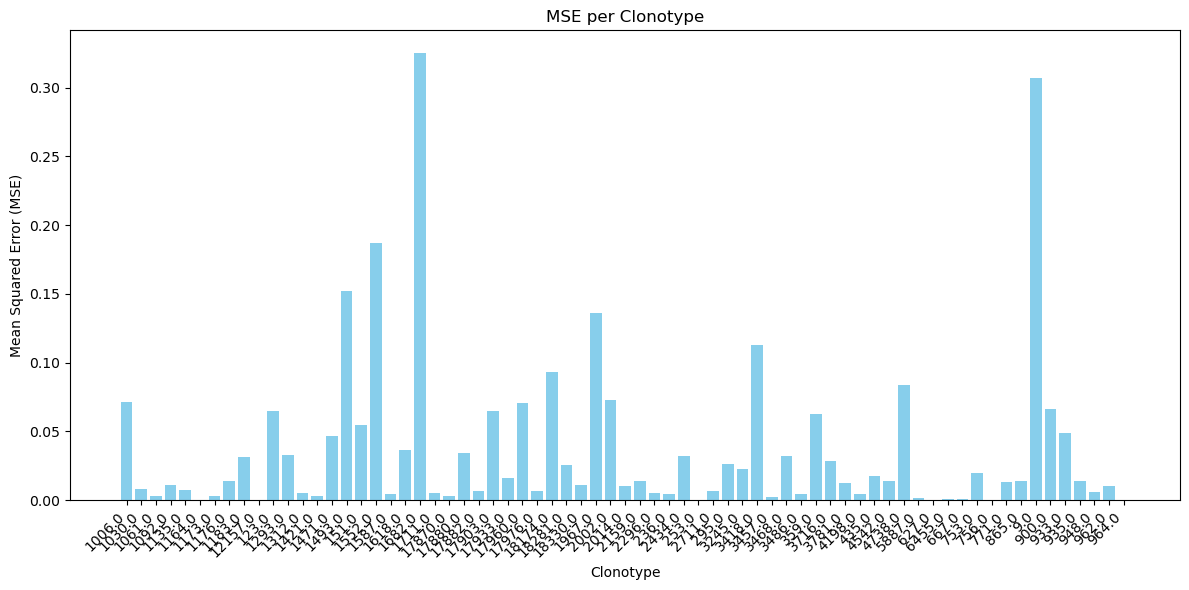

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Get the MSE by clonotype using the mse_clonotype function
mse_s1_clonotype, mean_mse = mse_clonotype(y_s1_pred, y_s1_test)

# Convert the MSE dictionary to lists for plotting
clonotypes = list(mse_s1_clonotype.keys())  # Clonotypes
mse_values = list(mse_s1_clonotype.values())  # Corresponding MSE values

# Plot the MSE for each clonotype
plt.figure(figsize=(12, 6))
plt.bar(clonotypes, mse_values, color='skyblue')
plt.xlabel('Clonotype')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('MSE per Clonotype')
plt.xticks(rotation=45, ha='right')  # Rotate the clonotype labels for readability
plt.tight_layout()

# Show the plot
plt.show()


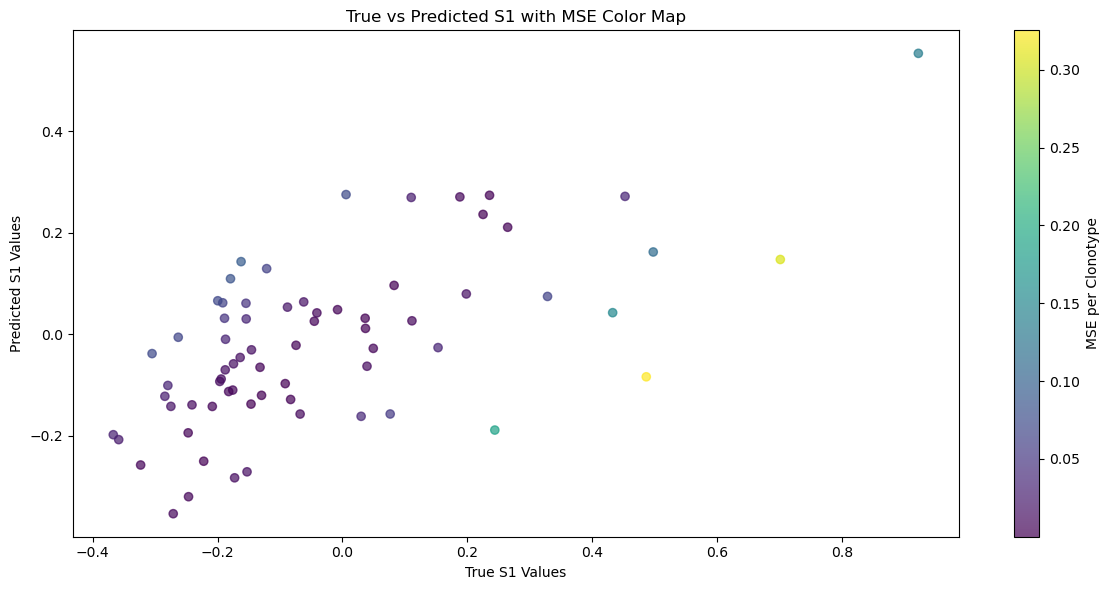

In [29]:
plt.figure(figsize=(12, 6))

# Plotting true vs predicted S1 for each clonotype (with a color map for MSE)
scatter = plt.scatter(y_s1_test, y_s1_pred, c=mse_values, cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label='MSE per Clonotype')

plt.xlabel('True S1 Values')
plt.ylabel('Predicted S1 Values')
plt.title('True vs Predicted S1 with MSE Color Map')
plt.tight_layout()
plt.show()




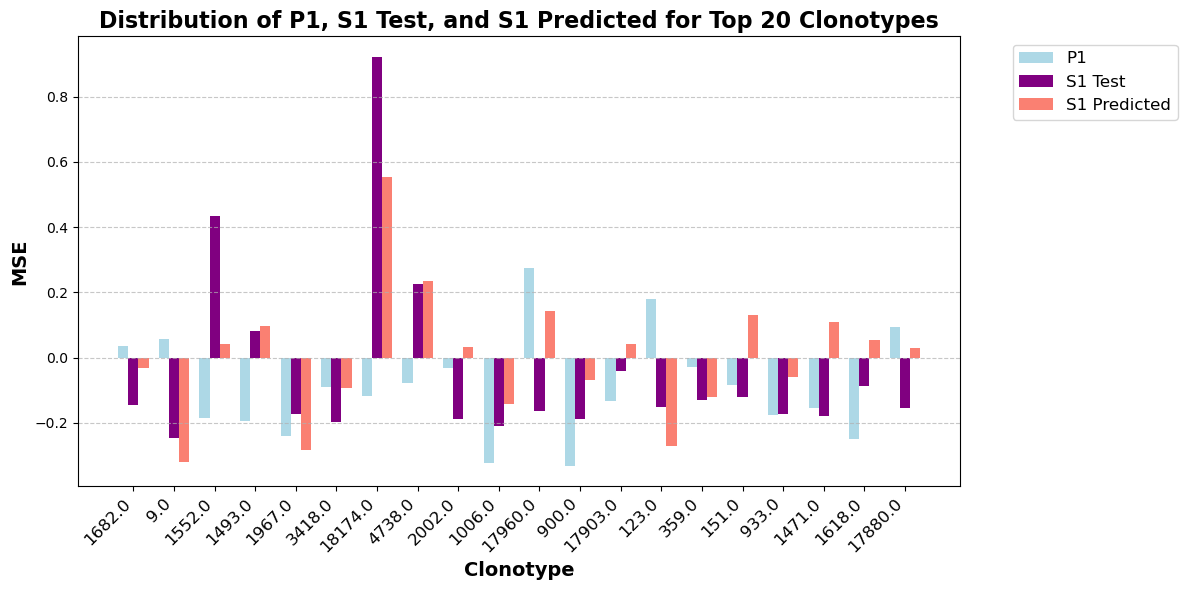

In [ ]:
# Step 2: Sort clonotypes by MSE and select the top 20 most interesting clonotypes
top_20_clonotypes = sorted(mse_s1_clonotype, key=mse_s1_clonotype.get, reverse=True)[:20]
#top_20_clonotypes = mse_s1_clonotype.keys()

# Step 3: Filter the data to only include the top 20 clonotypes
top_20_p1_test = [y_p1_test[test_clonotypes == clonotype].mean() for clonotype in top_20_clonotypes]
top_20_s1_test = [y_s1_test[test_clonotypes == clonotype].mean() for clonotype in top_20_clonotypes]
top_20_s1_pred = [y_s1_pred[test_clonotypes == clonotype].mean() for clonotype in top_20_clonotypes]

# Set up the figure
plt.figure(figsize=(12, 6))

# Define the bar width
bar_width = 0.25
index = np.arange(len(top_20_clonotypes))

# Plot each of the distributions
plt.bar(index - bar_width, top_20_p1_test, bar_width, label='P1', color='lightblue')
plt.bar(index, top_20_s1_test, bar_width, label='S1 Test', color='purple')
plt.bar(index + bar_width, top_20_s1_pred, bar_width, label='S1 Predicted', color='salmon')

# Add labels, title, and legend
plt.xlabel('Clonotype', fontsize=14, fontweight='bold', color='black')
plt.ylabel('MSE', fontsize=14, fontweight='bold', color='black')
plt.title('Distribution of P1, S1 Test, and S1 Predicted for Top 20 Clonotypes', fontsize=16, fontweight='bold', color='black')
plt.xticks(index, top_20_clonotypes, rotation=45, ha='right', fontsize=12, color='black')
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), fontsize=12)

# Adding gridlines to improve readability
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

# Adjust layout for better spacing and readability
plt.tight_layout()
plt.show()


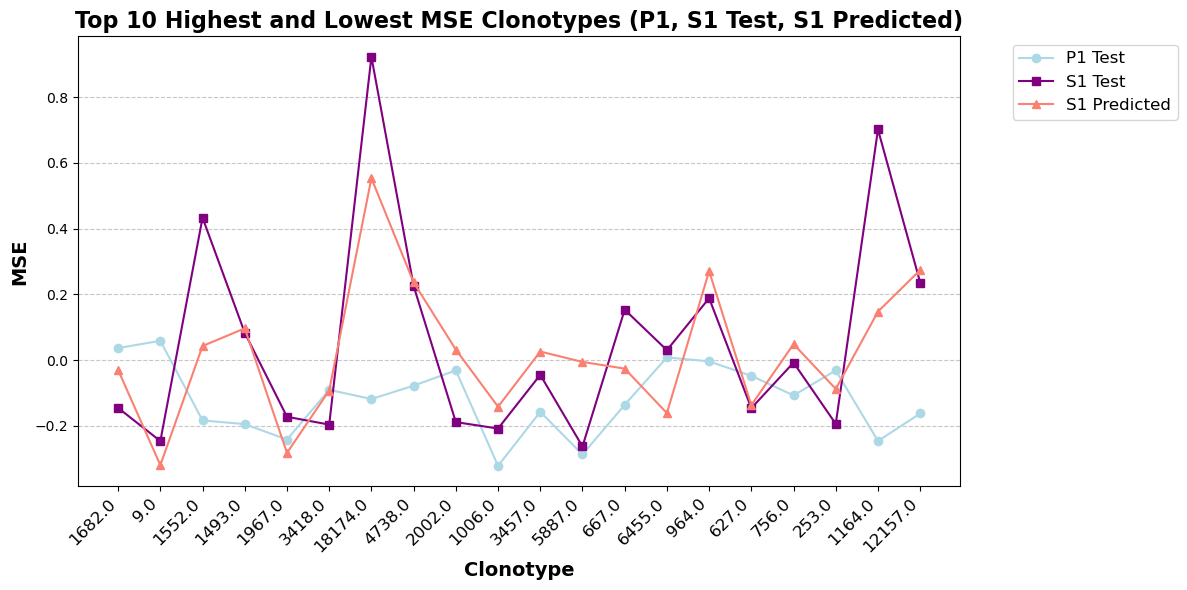

In [50]:
# Selecting the top 10 highest and top 10 lowest MSE clonotypes

# Sorting clonotypes by MSE values
sorted_clonotypes = sorted(mse_s1_clonotype, key=mse_s1_clonotype.get, reverse=True)

# Selecting the top 10 highest and lowest clonotypes based on MSE
top_10_highest_clonotypes = sorted_clonotypes[:10]  # Highest MSE
top_10_lowest_clonotypes = sorted_clonotypes[-10:]  # Lowest MSE

# Extracting corresponding MSE values for test and predicted data
top_10_highest_p1_test = [y_p1_aggregated[test_clonotypes == clonotype].mean() for clonotype in top_10_highest_clonotypes]
top_10_highest_s1_test = [y_s1_test[test_clonotypes == clonotype].mean() for clonotype in top_10_highest_clonotypes]
top_10_highest_s1_pred = [y_s1_pred[test_clonotypes == clonotype].mean() for clonotype in top_10_highest_clonotypes]

top_10_lowest_p1_test = [y_p1_aggregated[test_clonotypes == clonotype].mean() for clonotype in top_10_lowest_clonotypes]
top_10_lowest_s1_test = [y_s1_test[test_clonotypes == clonotype].mean() for clonotype in top_10_lowest_clonotypes]
top_10_lowest_s1_pred = [y_s1_pred[test_clonotypes == clonotype].mean() for clonotype in top_10_lowest_clonotypes]

# Combine data for visualization
clonotype_labels = top_10_highest_clonotypes + top_10_lowest_clonotypes
p1_test_values = top_10_highest_p1_test + top_10_lowest_p1_test
s1_test_values = top_10_highest_s1_test + top_10_lowest_s1_test
s1_pred_values = top_10_highest_s1_pred + top_10_lowest_s1_pred

# Creating a line plot
plt.figure(figsize=(12, 6))
x = np.arange(len(clonotype_labels))

plt.plot(x, p1_test_values, marker="o", linestyle="-", color="lightblue", label="P1 Test")
plt.plot(x, s1_test_values, marker="s", linestyle="-", color="purple", label="S1 Test")
plt.plot(x, s1_pred_values, marker="^", linestyle="-", color="salmon", label="S1 Predicted")

# Formatting the plot
plt.xlabel("Clonotype", fontsize=14, fontweight="bold", color="black")
plt.ylabel("MSE", fontsize=14, fontweight="bold", color="black")
plt.title("Top 10 Highest and Lowest MSE Clonotypes (P1, S1 Test, S1 Predicted)", fontsize=16, fontweight="bold", color="black")
plt.xticks(x, clonotype_labels, rotation=45, ha="right", fontsize=12, color="black")
plt.legend(loc="upper left", bbox_to_anchor=(1.05, 1), fontsize=12)
plt.grid(True, axis="y", linestyle="--", alpha=0.7)

# Adjust layout for better spacing and readability
plt.tight_layout()
 
plt.show()


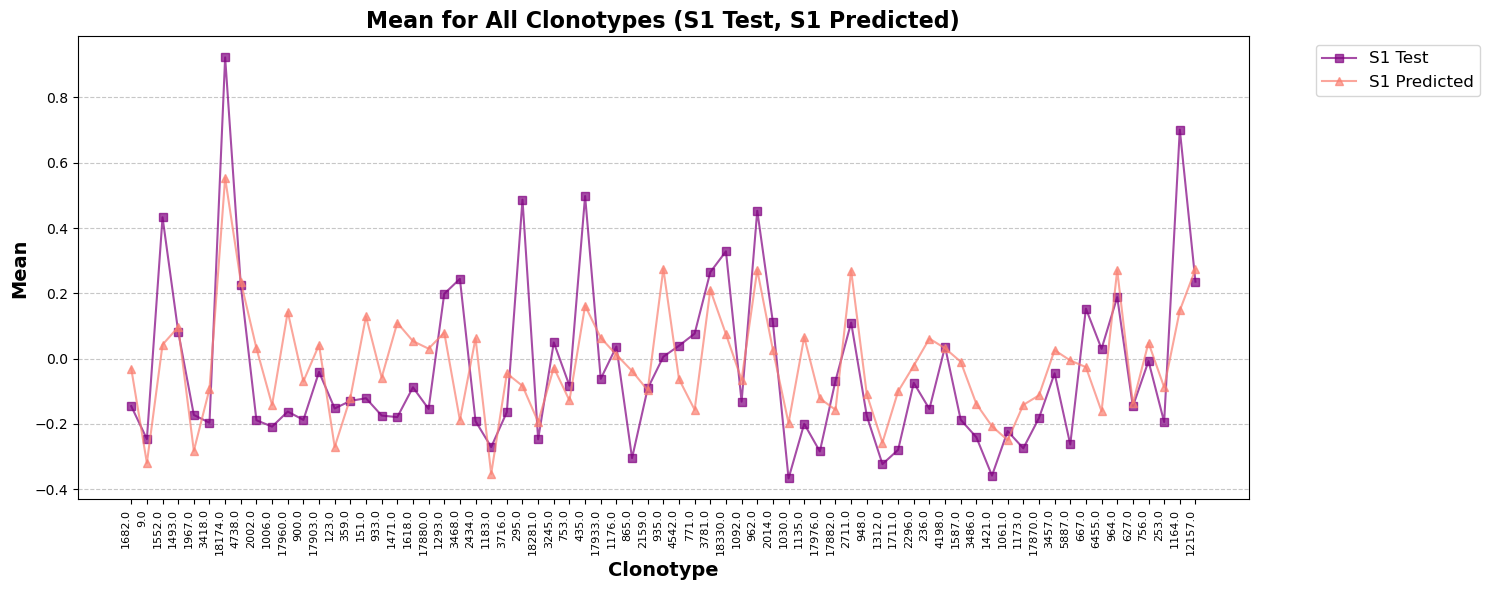

In [71]:
# Sorting clonotypes by MSE values
sorted_clonotypes = sorted(mse_s1_clonotype, key=mse_s1_clonotype.get, reverse=True)

# Extracting corresponding MSE values for test and predicted data
# all_p1_test = [y_p1_aggregated[test_clonotypes == clonotype].mean() for clonotype in sorted_clonotypes]
all_s1_test = [y_s1_test[test_clonotypes == clonotype].mean() for clonotype in sorted_clonotypes]
all_s1_pred = [y_s1_pred[test_clonotypes == clonotype].mean() for clonotype in sorted_clonotypes]

# Creating a line plot for all clonotypes
plt.figure(figsize=(15, 6))
x = np.arange(len(sorted_clonotypes))

# plt.plot(x, all_p1_test, marker="o", linestyle="-", color="lightblue", label="P1 Test", alpha=0.7)
plt.plot(x, all_s1_test, marker="s", linestyle="-", color="purple", label="S1 Test", alpha=0.7)
plt.plot(x, all_s1_pred, marker="^", linestyle="-", color="salmon", label="S1 Predicted", alpha=0.7)

# Formatting the plot
plt.xlabel("Clonotype", fontsize=14, fontweight="bold", color="black")
plt.ylabel("Mean", fontsize=14, fontweight="bold", color="black")
plt.title("Mean for All Clonotypes (S1 Test, S1 Predicted)", fontsize=16, fontweight="bold", color="black")
plt.xticks(x, sorted_clonotypes, rotation=90, ha="right", fontsize=8, color="black")  # Rotated for better visibility
plt.legend(loc="upper left", bbox_to_anchor=(1.05, 1), fontsize=12)
plt.grid(True, axis="y", linestyle="--", alpha=0.7)

# Adjust layout for better spacing and readability
plt.tight_layout()

plt.show()


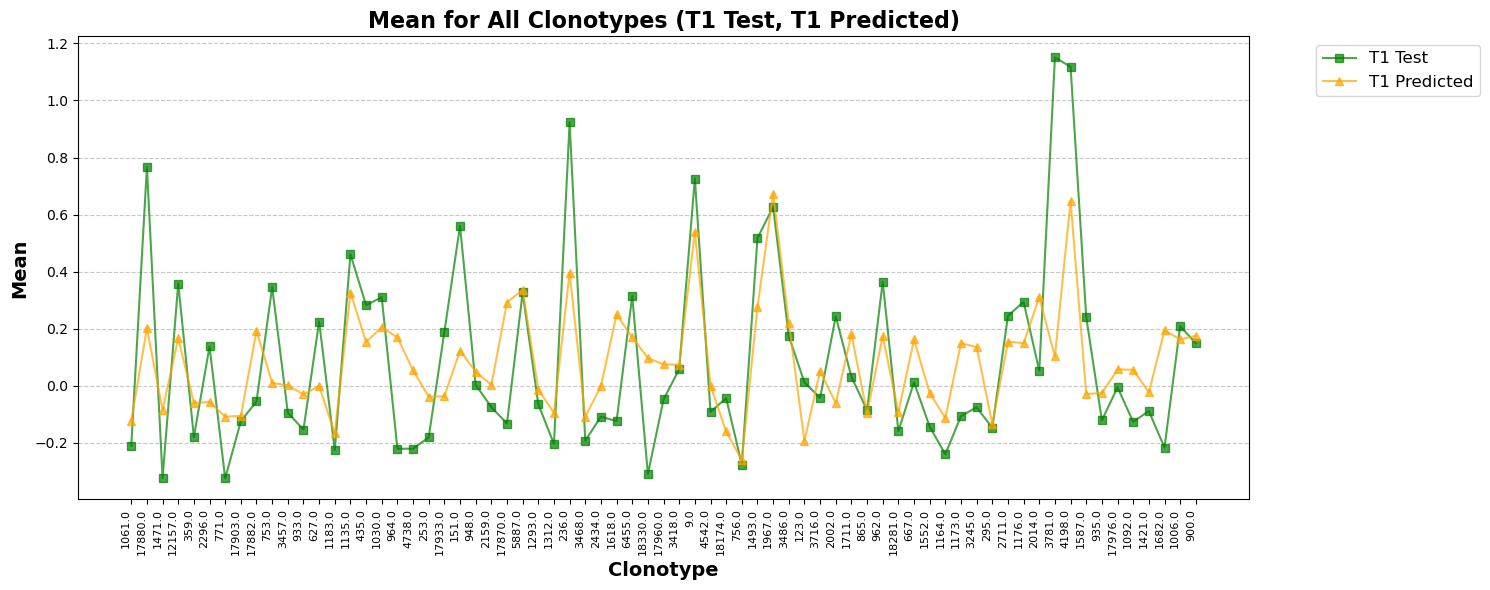

In [73]:
# Sorting clonotypes by MSE values
sorted_clonotypes = sorted(mse_t1_clonotype, key=mse_t1_clonotype.get, reverse=True)

# Extracting corresponding MSE values for test and predicted data
# all_p1_test = [y_p1_test[test_clonotypes == clonotype].mean() for clonotype in sorted_clonotypes]
all_t1_test = [y_t1_test[test_clonotypes == clonotype].mean() for clonotype in sorted_clonotypes]
all_t1_pred = [y_t1_pred[test_clonotypes == clonotype].mean() for clonotype in sorted_clonotypes]

# Creating a line plot for all clonotypes with T1 instead of S1
plt.figure(figsize=(15, 6))
x = np.arange(len(sorted_clonotypes))

# plt.plot(x, all_p1_test, marker="o", linestyle="-", color="lightblue", label="P1 Test", alpha=0.7)
plt.plot(x, all_t1_test, marker="s", linestyle="-", color="green", label="T1 Test", alpha=0.7)
plt.plot(x, all_t1_pred, marker="^", linestyle="-", color="orange", label="T1 Predicted", alpha=0.7)

# Formatting the plot
plt.xlabel("Clonotype", fontsize=14, fontweight="bold", color="black")
plt.ylabel("Mean", fontsize=14, fontweight="bold", color="black")
plt.title("Mean for All Clonotypes (T1 Test, T1 Predicted)", fontsize=16, fontweight="bold", color="black")
plt.xticks(x, sorted_clonotypes, rotation=90, ha="right", fontsize=8, color="black")  # Rotated for better visibility
plt.legend(loc="upper left", bbox_to_anchor=(1.05, 1), fontsize=12)
plt.grid(True, axis="y", linestyle="--", alpha=0.7)

# Adjust layout for better spacing and readability
plt.tight_layout()

plt.show()


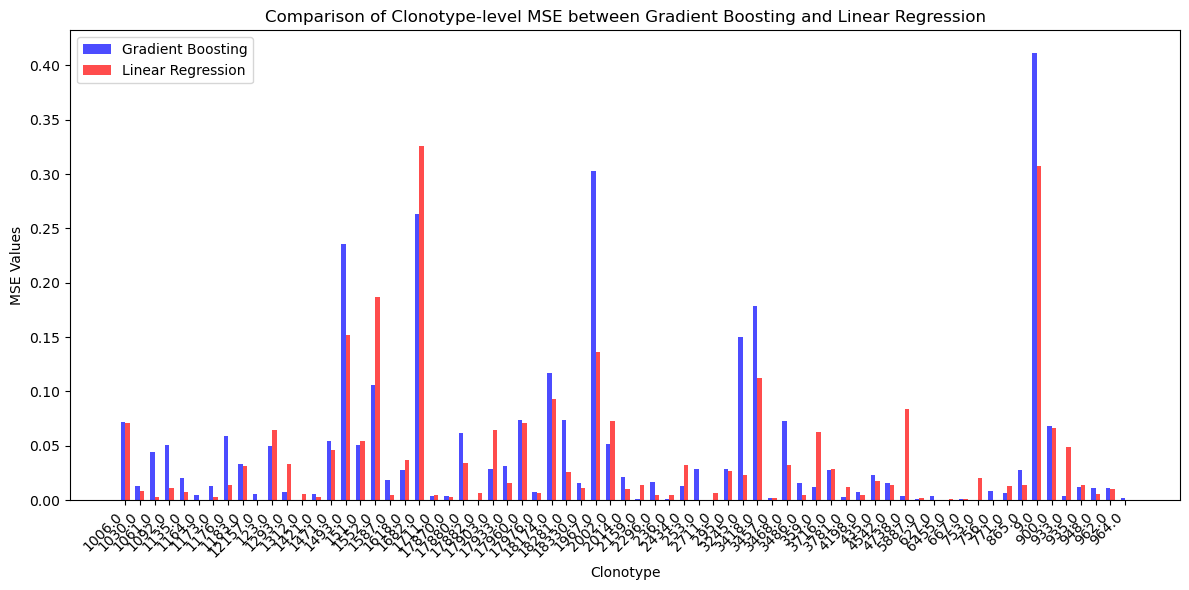

In [ ]:
# bar plot with individual clonotype-level MSE values

# Assuming we have clonotype-level MSE values for both models
clonotype_labels = list(mse_s1_clonotype.keys())  # Extract clonotype labels
mse_s1_clonotype_gb_values = list(mse_s1_clonotype_gb.values())  # MSE values for Gradient Boosting
mse_s1_clonotype_lr_values = list(mse_s1_clonotype.values())  # MSE values for Linear Regression

# Setting up the figure
fig, ax1 = plt.subplots(figsize=(12, 6))

# Define bar width
width = 0.3
x = np.arange(len(clonotype_labels))

# Plotting MSE for individual clonotypes for both models
ax1.bar(x - width / 2, mse_s1_clonotype_gb_values, width, label="Gradient Boosting", color="blue", alpha=0.7)
ax1.bar(x + width / 2, mse_s1_clonotype_lr_values, width, label="Linear Regression", color="red", alpha=0.7)

# Formatting the plot
ax1.set_xlabel("Clonotype")
ax1.set_ylabel("MSE Values")
ax1.set_title("Comparison of Clonotype-level MSE between Gradient Boosting and Linear Regression")
ax1.set_xticks(x)
ax1.set_xticklabels(clonotype_labels, rotation=45, ha="right", fontsize=10)
ax1.legend()

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()


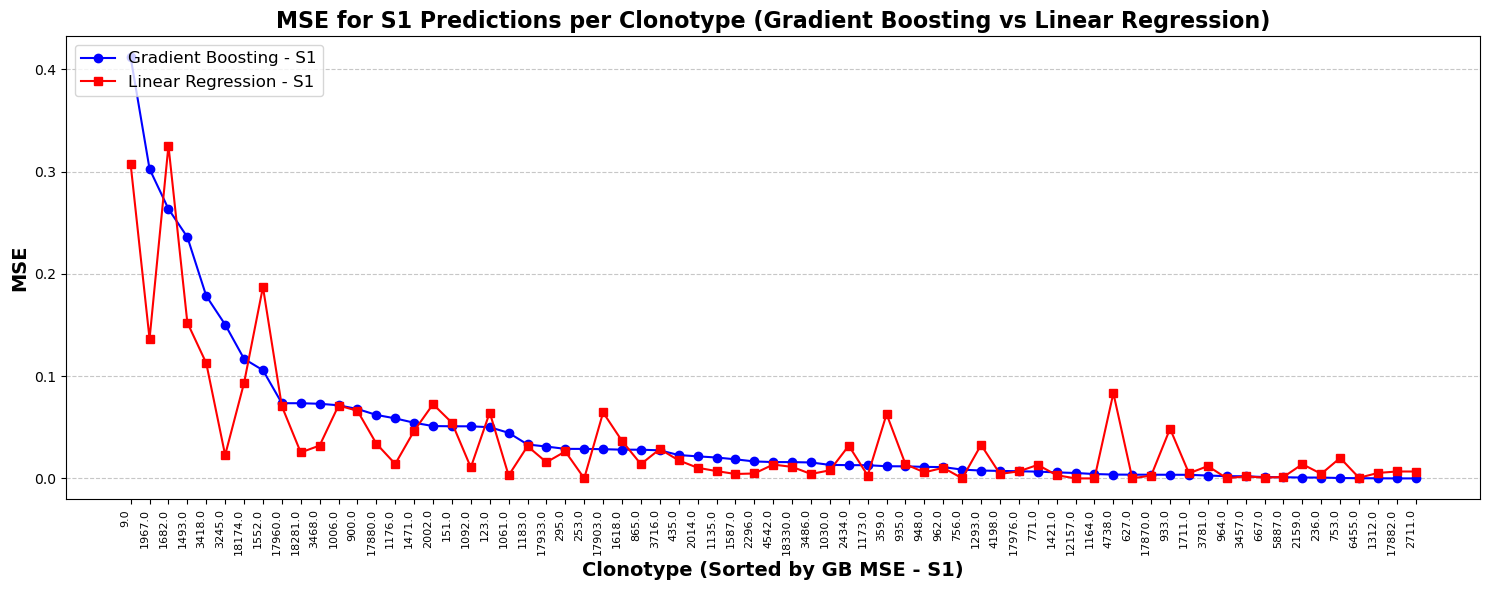

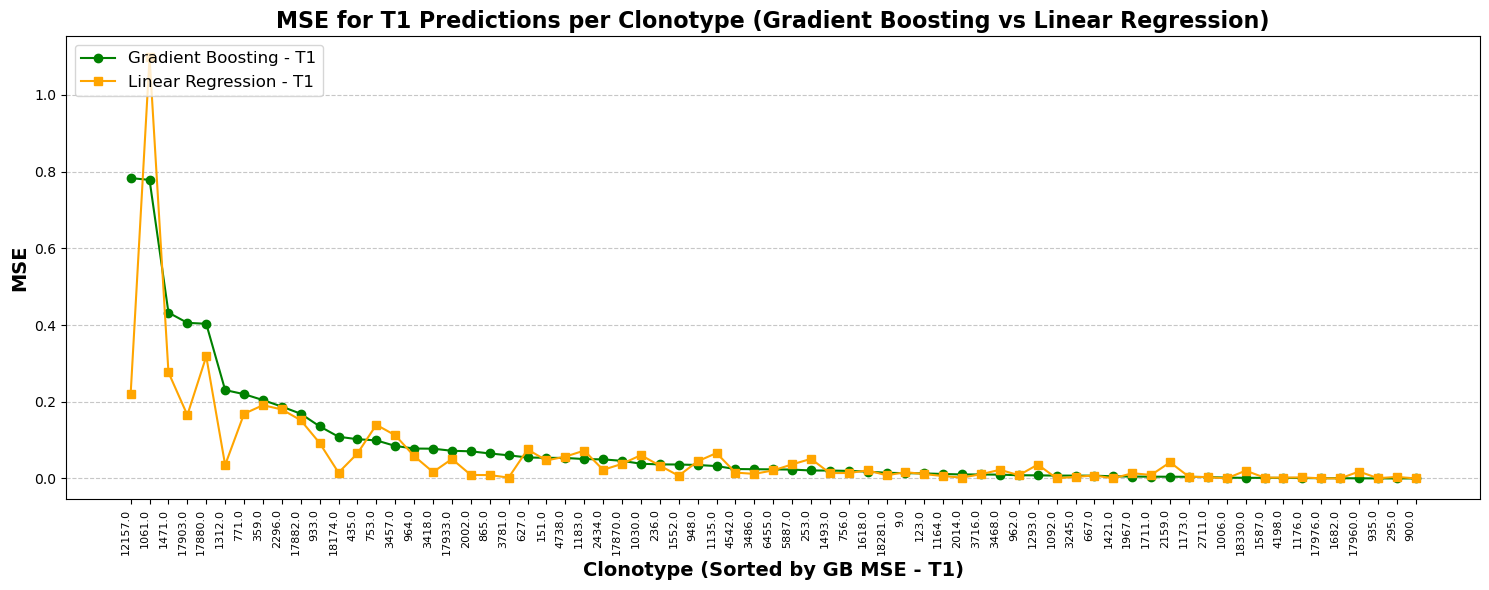

In [58]:
# Assuming mse_s1_clonotype_gb, mse_s1_clonotype_lr, mse_t1_clonotype_gb, and mse_t1_clonotype_lr exist

# Extract clonotype labels and corresponding MSE values for both models (S1)
clonotype_labels_s1 = list(mse_s1_clonotype_gb.keys())
mse_s1_values_gb = list(mse_s1_clonotype_gb.values())  # MSE values for Gradient Boosting (S1)
mse_s1_values_lr = list(mse_s1_clonotype.values())  # MSE values for Linear Regression (S1)

# Extract clonotype labels and corresponding MSE values for both models (T1)
clonotype_labels_t1 = list(mse_t1_clonotype_gb.keys())
mse_t1_values_gb = list(mse_t1_clonotype_gb.values())  # MSE values for Gradient Boosting (T1)
mse_t1_values_lr = list(mse_t1_clonotype.values())  # MSE values for Linear Regression (T1)

# Sorting clonotypes based on MSE values (Descending Order for Better Visualization)
sorted_indices_s1 = np.argsort(mse_s1_values_gb)[::-1]  # Sorting in descending order (S1)
sorted_clonotypes_s1 = [clonotype_labels_s1[i] for i in sorted_indices_s1]
sorted_mse_s1_gb = [mse_s1_values_gb[i] for i in sorted_indices_s1]
sorted_mse_s1_lr = [mse_s1_values_lr[i] for i in sorted_indices_s1]

sorted_indices_t1 = np.argsort(mse_t1_values_gb)[::-1]  # Sorting in descending order (T1)
sorted_clonotypes_t1 = [clonotype_labels_t1[i] for i in sorted_indices_t1]
sorted_mse_t1_gb = [mse_t1_values_gb[i] for i in sorted_indices_t1]
sorted_mse_t1_lr = [mse_t1_values_lr[i] for i in sorted_indices_t1]

# Creating a line plot comparing GB and LR MSE per clonotype (S1)
plt.figure(figsize=(15, 6))
x_s1 = np.arange(len(sorted_clonotypes_s1))

plt.plot(x_s1, sorted_mse_s1_gb, marker="o", linestyle="-", color="blue", label="Gradient Boosting - S1")
plt.plot(x_s1, sorted_mse_s1_lr, marker="s", linestyle="-", color="red", label="Linear Regression - S1")

# Formatting the plot (S1)
plt.xlabel("Clonotype (Sorted by GB MSE - S1)", fontsize=14, fontweight="bold", color="black")
plt.ylabel("MSE", fontsize=14, fontweight="bold", color="black")
plt.title("MSE for S1 Predictions per Clonotype (Gradient Boosting vs Linear Regression)", fontsize=16, fontweight="bold", color="black")
plt.xticks(x_s1, sorted_clonotypes_s1, rotation=90, ha="right", fontsize=8, color="black")
plt.legend(loc="upper left", fontsize=12)
plt.grid(True, axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

# Creating a line plot comparing GB and LR MSE per clonotype (T1)
plt.figure(figsize=(15, 6))
x_t1 = np.arange(len(sorted_clonotypes_t1))

plt.plot(x_t1, sorted_mse_t1_gb, marker="o", linestyle="-", color="green", label="Gradient Boosting - T1")
plt.plot(x_t1, sorted_mse_t1_lr, marker="s", linestyle="-", color="orange", label="Linear Regression - T1")

# Formatting the plot (T1)
plt.xlabel("Clonotype (Sorted by GB MSE - T1)", fontsize=14, fontweight="bold", color="black")
plt.ylabel("MSE", fontsize=14, fontweight="bold", color="black")
plt.title("MSE for T1 Predictions per Clonotype (Gradient Boosting vs Linear Regression)", fontsize=16, fontweight="bold", color="black")
plt.xticks(x_t1, sorted_clonotypes_t1, rotation=90, ha="right", fontsize=8, color="black")
plt.legend(loc="upper left", fontsize=12)
plt.grid(True, axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


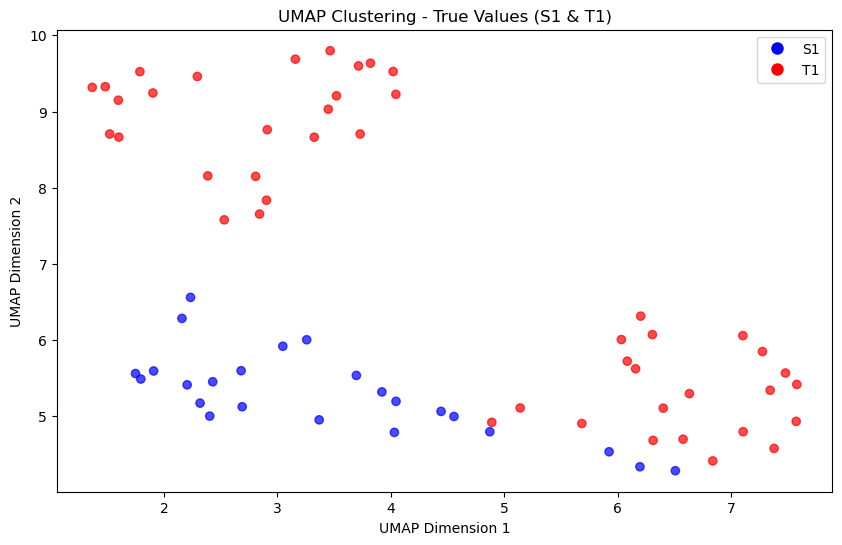

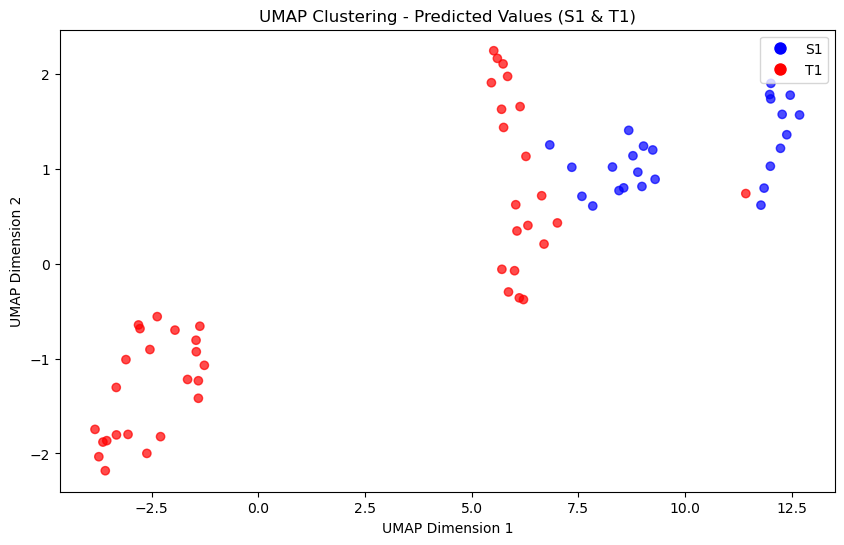

In [75]:
from sklearn.preprocessing import StandardScaler

# Standardize the data for better UMAP performance
scaler = StandardScaler()

# Prepare data
data_true = np.column_stack((y_s1_test, y_t1_test))  # True values (S1 & T1)
data_pred = np.column_stack((y_s1_pred, y_t1_pred))  # Predicted values (S1 & T1)

# Scale the data
data_true_scaled = scaler.fit_transform(data_true)
data_pred_scaled = scaler.fit_transform(data_pred)

# Apply UMAP for dimensionality reduction
reducer = umap.UMAP(n_neighbors=10, min_dist=0.1, metric="euclidean", random_state=42)

embedding_true = reducer.fit_transform(data_true_scaled)  # UMAP for True values
embedding_pred = reducer.fit_transform(data_pred_scaled)  # UMAP for Predicted values

# Assign colors: S1 (blue), T1 (red)
colors = ["blue", "red"]
labels = ["S1", "T1"]
target_colors_true = np.where(y_s1_test > y_t1_test, colors[0], colors[1])  # Color based on whether S1 > T1
target_colors_pred = np.where(y_s1_pred > y_t1_pred, colors[0], colors[1])  # Same for predicted

# Plot UMAP for True values
plt.figure(figsize=(10, 6))
plt.scatter(embedding_true[:, 0], embedding_true[:, 1], c=target_colors_true, alpha=0.7)
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.title("UMAP Clustering - True Values (S1 & T1)")
plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[i], markersize=10, label=labels[i]) for i in range(2)])
plt.show()

# Plot UMAP for Predicted values
plt.figure(figsize=(10, 6))
plt.scatter(embedding_pred[:, 0], embedding_pred[:, 1], c=target_colors_pred, alpha=0.7)
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.title("UMAP Clustering - Predicted Values (S1 & T1)")
plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[i], markersize=10, label=labels[i]) for i in range(2)])
plt.show()





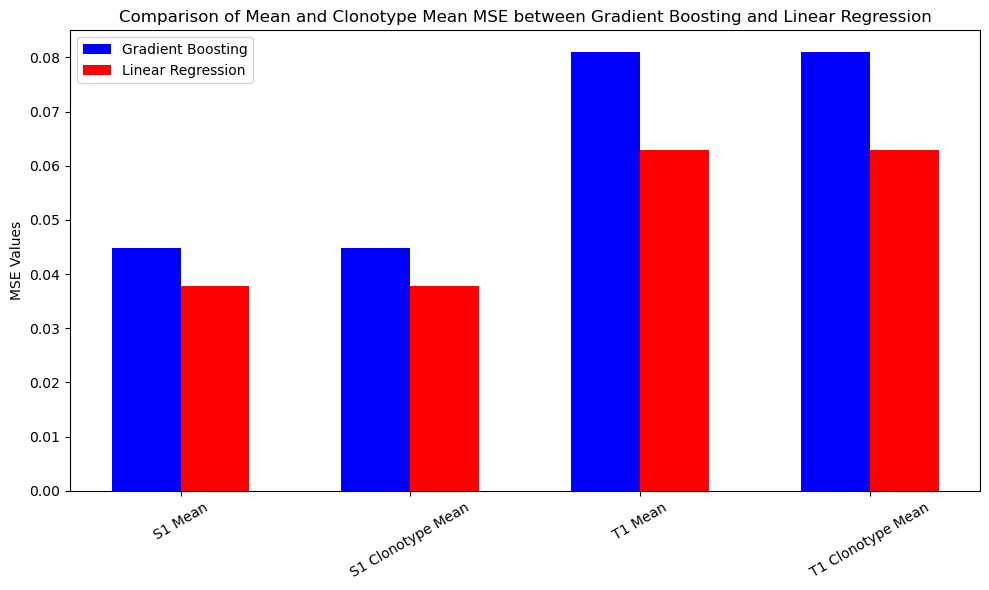

In [39]:
# Data preparation
models = ["Gradient Boosting", "Linear Regression"]
metrics = ["S1 Mean", "S1 Clonotype Mean", "T1 Mean", "T1 Clonotype Mean"]

# Values for Gradient Boosting (GB)
mse_s1_gb_values = [mse_s1_gb, mse_s1_mean_gb, mse_t1_gb, mse_t1_mean_gb]

# Values for Linear Regression (LR)
mse_s1_lr_values = [mse_s1, mse_s1_mean, mse_t1, mse_t1_mean]

# Creating the bar plot
x = np.arange(len(metrics))
width = 0.3

fig, ax = plt.subplots(figsize=(10, 6))

bars1 = ax.bar(x - width / 2, mse_s1_gb_values, width, label="Gradient Boosting", color="blue")
bars2 = ax.bar(x + width / 2, mse_s1_lr_values, width, label="Linear Regression", color="red")

ax.set_ylabel("MSE Values")
ax.set_title("Comparison of Mean and Clonotype Mean MSE between Gradient Boosting and Linear Regression")
ax.set_xticks(x)
ax.set_xticklabels(metrics, rotation=30)
ax.legend()

plt.tight_layout()
plt.show()


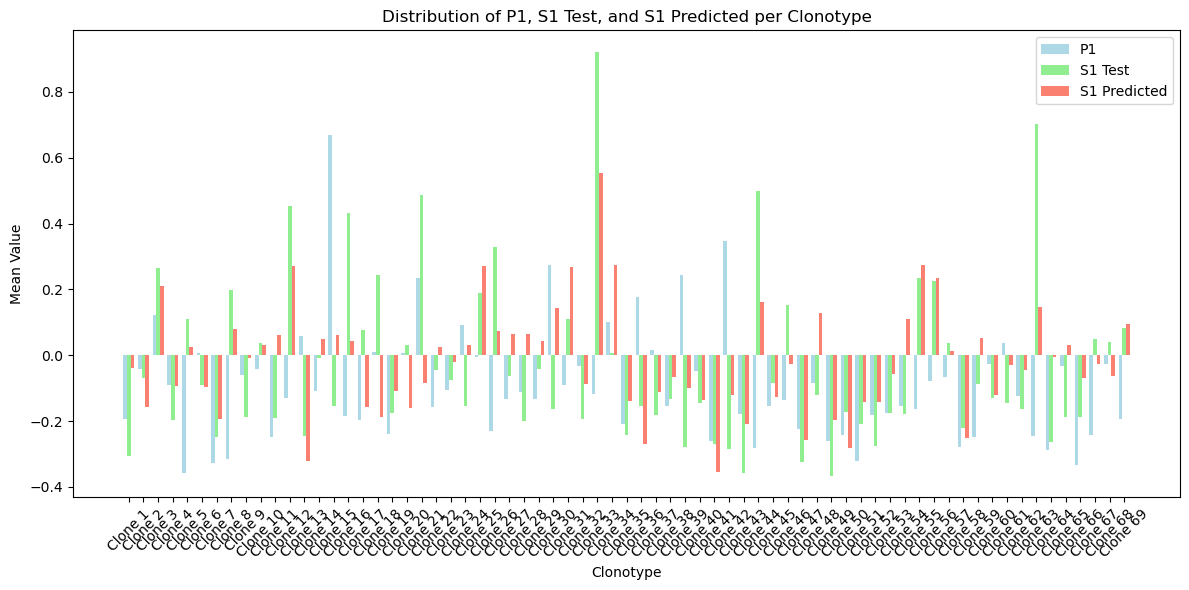

In [ ]:
#compare the distribution of P1, S1_test, and S1_pred per clonotype

# Plotting the results
clonotypes = [f'Clone {i+1}' for i in range(len(np.unique(test_clonotypes)))]

# Set up the figure
plt.figure(figsize=(12, 6))

# Define the bar width
bar_width = 0.25
index = np.arange(len(clonotypes))

# Plot each of the distributions
plt.bar(index - bar_width, y_p1_test, bar_width, label='P1', color='lightblue')
plt.bar(index, y_s1_test, bar_width, label='S1 Test', color='lightgreen')
plt.bar(index + bar_width, y_s1_pred, bar_width, label='S1 Predicted', color='salmon')

# Add labels, title, and legend
plt.xlabel('Clonotype')
plt.ylabel('Mean Value')
plt.title('Distribution of P1, S1 Test, and S1 Predicted per Clonotype')
plt.xticks(index, clonotypes, rotation=45)
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


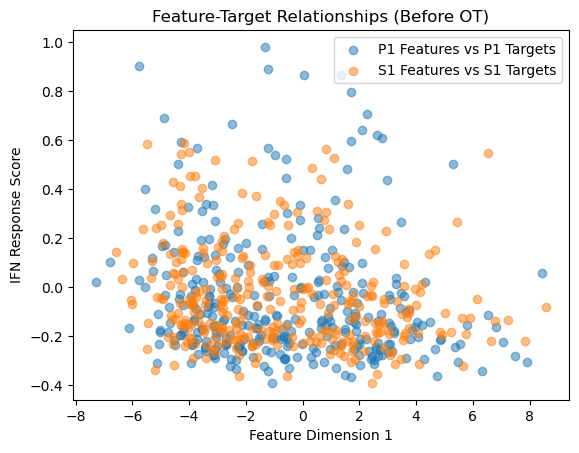

'# Scatter plot of paired features (after OT) vs targets\nplt.scatter(paired_features_p1[:, 0], paired_targets_p1, alpha=0.5, label="Paired P1 Features vs Targets")\nplt.scatter(paired_features_s1[:, 0], paired_targets_s1, alpha=0.5, label="Paired S1 Features vs Targets")\nplt.xlabel("Feature Dimension 1")\nplt.ylabel("IFN Response Score")\nplt.title("Feature-Target Relationships (After OT)")\nplt.legend()\nplt.show()'

In [32]:
# Scatter plot of original features vs targets (no OT pairing)
plt.scatter(X_p1[:, 0], y_p1, alpha=0.5, label="P1 Features vs P1 Targets")
plt.scatter(X_s1[:, 0], y_s1, alpha=0.5, label="S1 Features vs S1 Targets")
plt.xlabel("Feature Dimension 1")
plt.ylabel("IFN Response Score")
plt.title("Feature-Target Relationships (Before OT)")
plt.legend()
plt.show()

"""# Scatter plot of paired features (after OT) vs targets
plt.scatter(paired_features_p1[:, 0], paired_targets_p1, alpha=0.5, label="Paired P1 Features vs Targets")
plt.scatter(paired_features_s1[:, 0], paired_targets_s1, alpha=0.5, label="Paired S1 Features vs Targets")
plt.xlabel("Feature Dimension 1")
plt.ylabel("IFN Response Score")
plt.title("Feature-Target Relationships (After OT)")
plt.legend()
plt.show()"""


In [33]:
"""# Split data into training and testing sets
#X_s1_train, X_s1_test, y_s1_train, y_s1_test = train_test_split(X_regression, y_s1_regression, test_size=0.2, random_state=42)
X_t1_train, X_t1_test, y_t1_train, y_t1_test = train_test_split(X_regression_t1, y_regression_t1, test_size=0.2, random_state=42)

# Initialize and train the model
#model = LinearRegression()
model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
#model.fit(X_s1_train, y_s1_train)
model.fit(X_t1_train, y_t1_train)


# Predict on the test set
#y_s1_pred = model.predict(X_s1_test)
y_t1_pred = model.predict(X_t1_test)"""

'# Split data into training and testing sets\n#X_s1_train, X_s1_test, y_s1_train, y_s1_test = train_test_split(X_regression, y_s1_regression, test_size=0.2, random_state=42)\nX_t1_train, X_t1_test, y_t1_train, y_t1_test = train_test_split(X_regression_t1, y_regression_t1, test_size=0.2, random_state=42)\n\n# Initialize and train the model\n#model = LinearRegression()\nmodel = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)\n#model.fit(X_s1_train, y_s1_train)\nmodel.fit(X_t1_train, y_t1_train)\n\n\n# Predict on the test set\n#y_s1_pred = model.predict(X_s1_test)\ny_t1_pred = model.predict(X_t1_test)'

In [34]:
"""# Plot feature importances
importances = model.feature_importances_
num_features = len(importances)

plt.bar(range(num_features), importances)
plt.xlabel("Feature Index")
plt.ylabel("Importance")
plt.title("Feature Importance in Gradient Boosting")
plt.show()"""

'# Plot feature importances\nimportances = model.feature_importances_\nnum_features = len(importances)\n\nplt.bar(range(num_features), importances)\nplt.xlabel("Feature Index")\nplt.ylabel("Importance")\nplt.title("Feature Importance in Gradient Boosting")\nplt.show()'

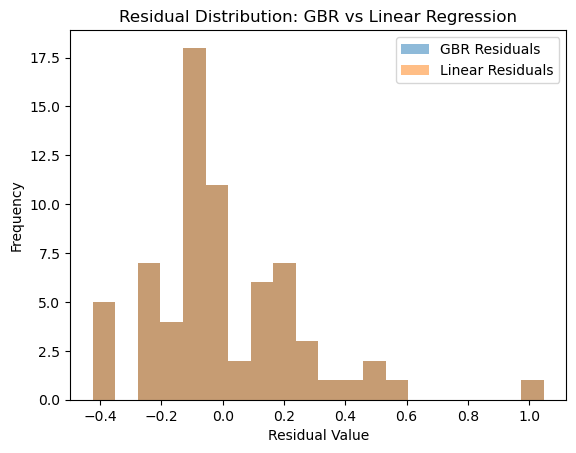

GBR MSE: 0.0629
Linear Regression MSE: 0.0629


In [35]:
# Compute residuals for GBR
gbr_residuals = y_t1_test - y_t1_pred

# Train a Linear Regression model for comparison
linear_model = LinearRegression()
linear_model.fit(X_t1_train, y_t1_train)
y_t1_linear_pred = linear_model.predict(X_t1_test)

# Compute residuals for Linear Regression
linear_residuals = y_t1_test - y_t1_linear_pred

# Plot residuals
plt.hist(gbr_residuals, bins=20, alpha=0.5, label="GBR Residuals")
plt.hist(linear_residuals, bins=20, alpha=0.5, label="Linear Residuals")
plt.xlabel("Residual Value")
plt.ylabel("Frequency")
plt.title("Residual Distribution: GBR vs Linear Regression")
plt.legend()
plt.show()

# Calculate residual statistics
gbr_mse = mean_squared_error(y_t1_test, y_t1_pred)
linear_mse = mean_squared_error(y_t1_test, y_t1_linear_pred)

print(f"GBR MSE: {gbr_mse:.4f}")
print(f"Linear Regression MSE: {linear_mse:.4f}")


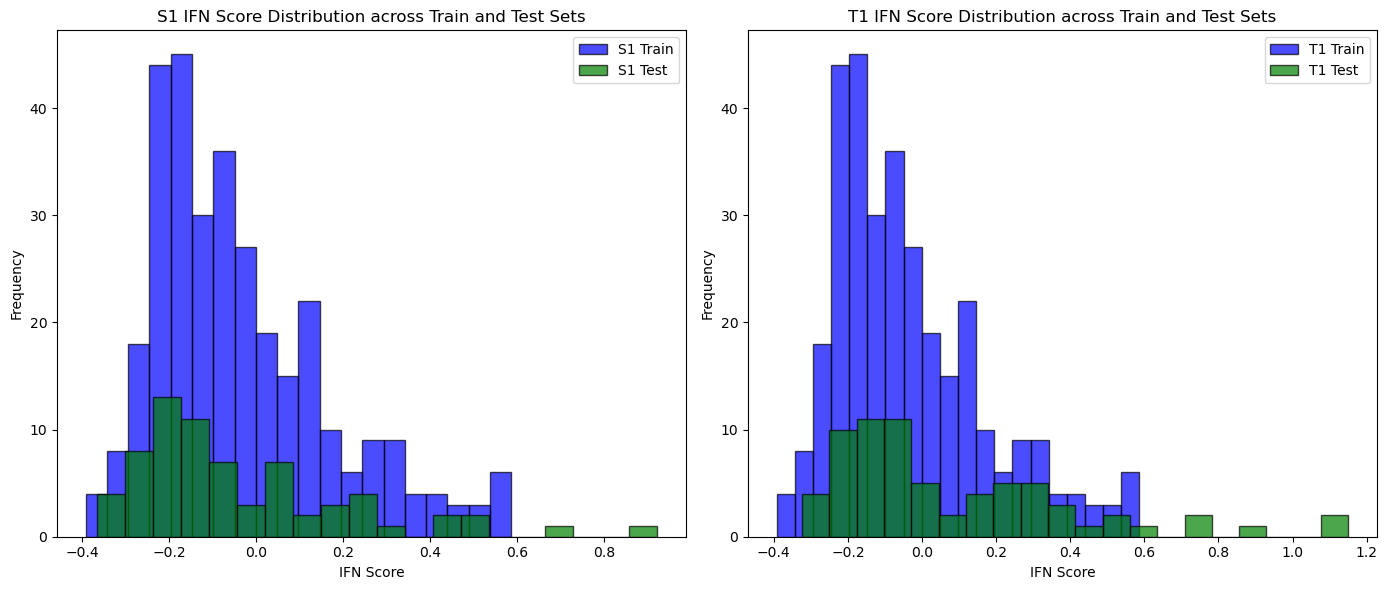

In [37]:
# plot the IFN score for train and  test subset
import matplotlib.pyplot as plt

# Plot IFN score distributions for train and test sets
plt.figure(figsize=(14, 6))

# Train distribution
plt.subplot(1, 2, 1)
plt.hist(y_s1_train, bins=20, alpha=0.7, label="S1 Train", color="blue", edgecolor="black")
plt.hist(y_s1_test, bins=20, alpha=0.7, label="S1 Test", color="green", edgecolor="black")
plt.title("S1 IFN Score Distribution across Train and Test Sets")
plt.xlabel("IFN Score")
plt.ylabel("Frequency")
plt.legend()

# Test distribution
plt.subplot(1, 2, 2)
plt.hist(y_t1_train, bins=20, alpha=0.7, label="T1 Train", color="blue", edgecolor="black")
plt.hist(y_t1_test, bins=20, alpha=0.7, label="T1 Test", color="green", edgecolor="black")
plt.title("T1 IFN Score Distribution across Train and Test Sets")
plt.xlabel("IFN Score")
plt.ylabel("Frequency")
plt.legend()

plt.tight_layout()
plt.show()

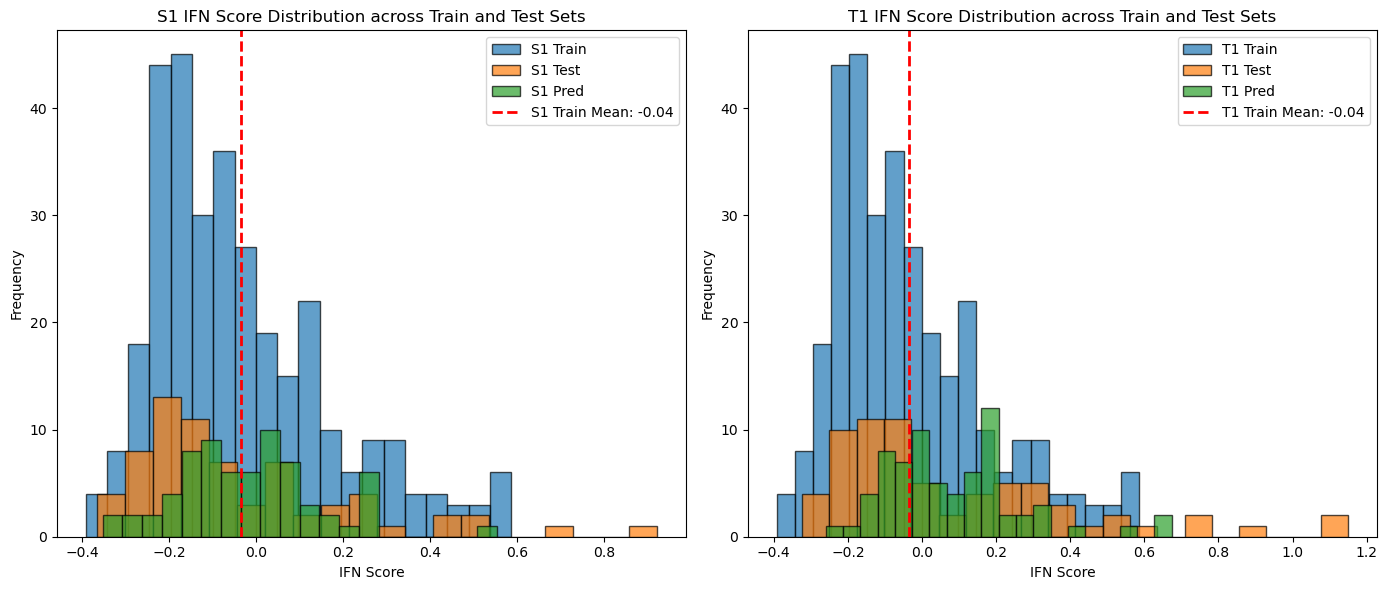

In [38]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate the means of the distributions
mean_s1_train = np.mean(y_s1_train)

mean_t1_train = np.mean(y_t1_train)

# Plot IFN score distributions for train and test sets
plt.figure(figsize=(14, 6))

# Train distribution
plt.subplot(1, 2, 1)
plt.hist(y_s1_train, bins=20, alpha=0.7, label="S1 Train", edgecolor="black")
plt.hist(y_s1_test, bins=20, alpha=0.7, label="S1 Test", edgecolor="black")
plt.hist(y_s1_pred, bins=20, alpha=0.7, label="S1 Pred", edgecolor="black")
plt.axvline(mean_s1_train, color='red', linestyle='dashed', linewidth=2, label=f"S1 Train Mean: {mean_s1_train:.2f}")
plt.title("S1 IFN Score Distribution across Train and Test Sets")
plt.xlabel("IFN Score")
plt.ylabel("Frequency")
plt.legend()

# Test distribution
plt.subplot(1, 2, 2)
plt.hist(y_t1_train, bins=20, alpha=0.7, label="T1 Train", edgecolor="black")
plt.hist(y_t1_test, bins=20, alpha=0.7, label="T1 Test", edgecolor="black")
plt.hist(y_t1_pred, bins=20, alpha=0.7, label="T1 Pred", edgecolor="black")
plt.axvline(mean_t1_train, color='red', linestyle='dashed', linewidth=2, label=f"T1 Train Mean: {mean_t1_train:.2f}")
plt.title("T1 IFN Score Distribution across Train and Test Sets")
plt.xlabel("IFN Score")
plt.ylabel("Frequency")
plt.legend()

plt.tight_layout()
plt.show()
